## **Data Downloading**

For our tutorial, we will be utilizing the Cornell Movie-Dialogs Corpus, a vast collection of over 220,000 conversational exchanges between more than 10,000 pairs of characters in various movies and TV shows.![BERT1.png](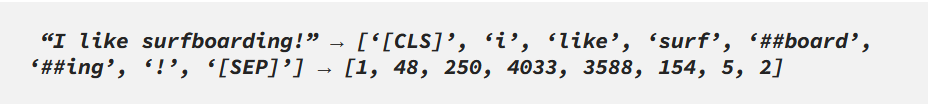![BERT1.png](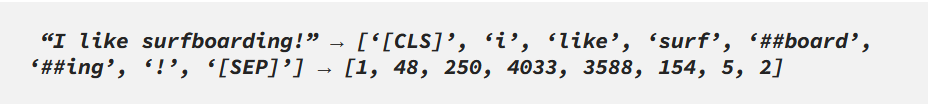![BERT1.png](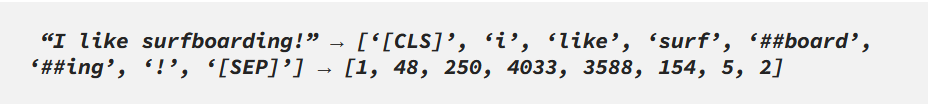![BERT1.png](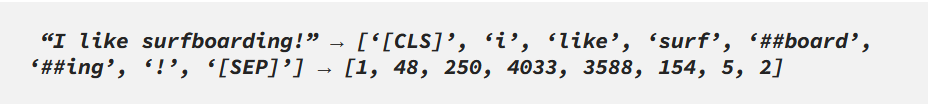![BERT1.png](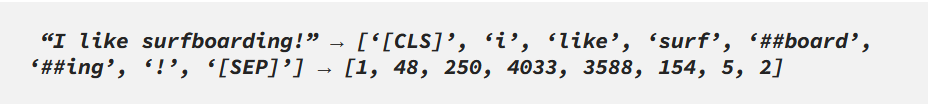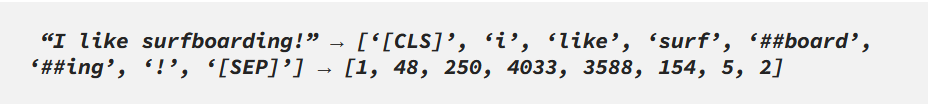)))))

In [ ]:
!pip install transformers datasets tokenizers
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
--2023-12-18 08:21:10--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  26.8MB/s    in 0.4s    

2023-12-18 08:21:10 (26.8 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



## **Import Libraries**

In [ ]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

## Preprocessing of dataset

1.   The dataset comprises two files, 'movie_conversations.txt' and 'movie_lines.txt'.
2.   In 'movie_lines.txt,' we use the delimiter '+++ $ +++' to split and organize line details (ID, character ID, movie ID, and dialogue text) into a dictionary named line_dic.
3.   Moving on, we create question-answer pairs by pairing each line's text with the subsequent line's text within each conversation in 'movie_conversations.txt.'
4.   Finally, to adhere to a standard input sequence length of 64 tokens in various NLP tasks, we truncate the text, retaining only the initial 64 tokens.




In [ ]:
MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()
        second = lines_dic[ids[i+1]].strip()

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

Let’s take a look at one of the random pairs in the dataset

In [ ]:
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


## WordPiece Tokenization
Tokenization involves the segmentation of a text into smaller units known as "tokens," which are subsequently transformed into a numerical representation.An example of this would be splitting the sentence-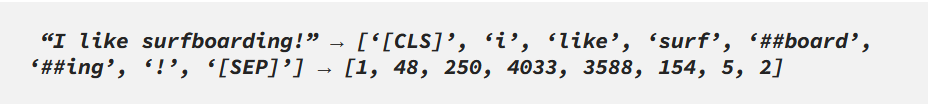

To train the BertWordPieceTokenizer using the transformer library, we will follow these steps:
1. Save the conversation text into multiple .txt files, each containing a batch of N=10000 samples.
2. Define the BertWordPieceTokenizer with the following parameters:
        clean_text: Remove control characters.
        handle_chinese_chars: Include spaces around Chinese characters.
        strip_accents: Remove accents, e.g., é → e, ô → o.
        lowercase: Treat capital and lowercase characters as equal.
3. Train the tokenizer by specifying:
        vocab_size: The total number of tokens.
        min_frequency: Minimum frequency for a pair of tokens to be merged.
        special_tokens: List of special tokens used by BERT.
        limit_alphabet: Maximum number of different characters.
        wordpieces_prefix: Prefix added to word pieces (e.g., ##ing).



In [ ]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train(
    files=paths,
    vocab_size=30_000,
    min_frequency=5,
    limit_alphabet=1000,
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

100%|██████████| 221616/221616 [00:00<00:00, 729514.59it/s]
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


Here's a concise overview of the special tokens used in BERT:

   * **[CLS]**: Represents classification, serving as the Start of Sentence (SOS). It encapsulates the meaning of the entire sentence.

   * **[SEP]**: Serves as the End of Sentence (EOS) and acts as a separation token between the first and second sentences in a pair.

   * **[PAD]**: Used to pad sentences to ensure equal length during processing. It doesn't contribute to the gradient during training (with an id of 0).

   * **[MASK]**: Employed for word replacement during masked language prediction. This token is utilized when some words are randomly masked, and the model aims to predict those masked words.

   *  **[UNK]**: Acts as a replacement for a token if it's not found in the tokenizer's vocabulary. It represents an unknown or out-of-vocabulary token.



## **Pre-Training Strategy**
BERT, or Bidirectional Encoder Representations from Transformers, is a masked language model (MLM). As a masked language model, BERT is designed to predict missing or masked words within a given context. This task is part of the pre-training phase of BERT.
### **Masked Language Model (MLM)**
The initial concept involves masking 15% of the words with the [MASK] token for prediction. However, a drawback arises because the model is conditioned to predict only when the [MASK] token is present, rather than encouraging it to predict the correct tokens regardless of the input token. To address this, within the 15% of tokens selected for masking:

    * 80% of the tokens are substituted with the [MASK] token.
    * 10% of the tokens are randomly replaced with another token.
    * 10% of the tokens remain unchanged during the masking process.

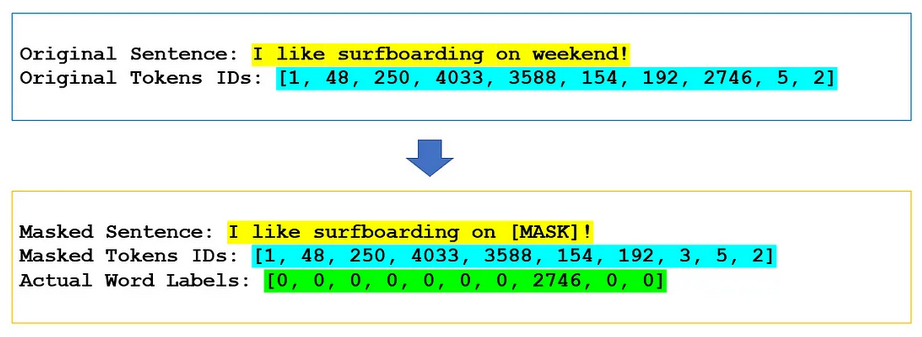



## **Custom PyTorch Dataset**

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

We will print a sample output from the prepared dataset and we will see 4 keys output

* **bert_input**  for tokenized sentences
* **bert_label** stores original words of selected masking tokens
* **segment_label** as the identifier for sentence A or B, this allows the model to distinguish between sentences
* **is_next** as truth label for whether the two sentences are related

In [ ]:
train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print(train_data[random.randrange(len(train_data))])

{'bert_input': tensor([   1, 1877,  220,   16,   16, 3964,   16,   16,  237,    3,  294, 4827,
          40,    3,    3,    2,  377,   11,   59,  493,    3,  250,    3,  360,
        3100, 9138,   17,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'bert_label': tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0, 302,   0,   0,   0, 496,
         34,   0,   0,   0,   0,   0, 314,   0, 146,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]), 'segment_label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## **Embedding**
BERT's embedding consists of three primary components: token embeddings, segment embeddings, and position embeddings.
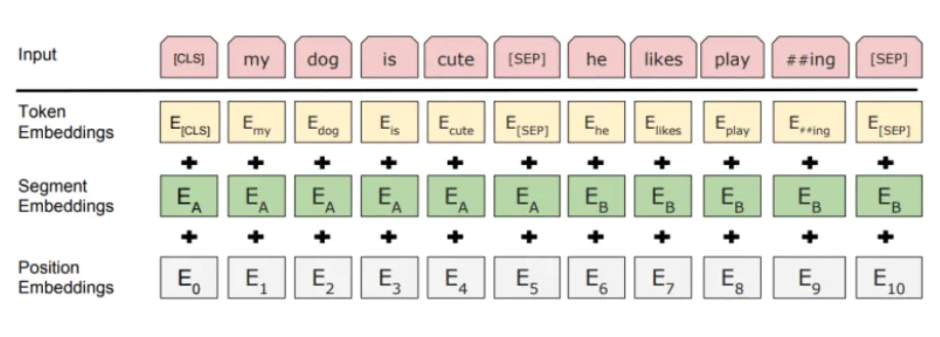

Transformer model did a position embedding for each token in the input using the formula.
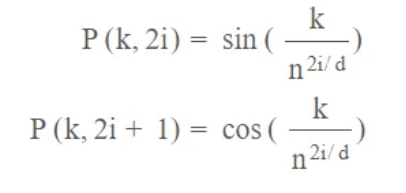

where

* k: Position of an object in input sequence, 0 < k < L/2
* d: Dimension of the output embedding space
* n: User defined scalar. Default by 10,000
* i: Used for mapping to column indices 0 < i < d/2. A single value of i maps to both sine and cosine functions



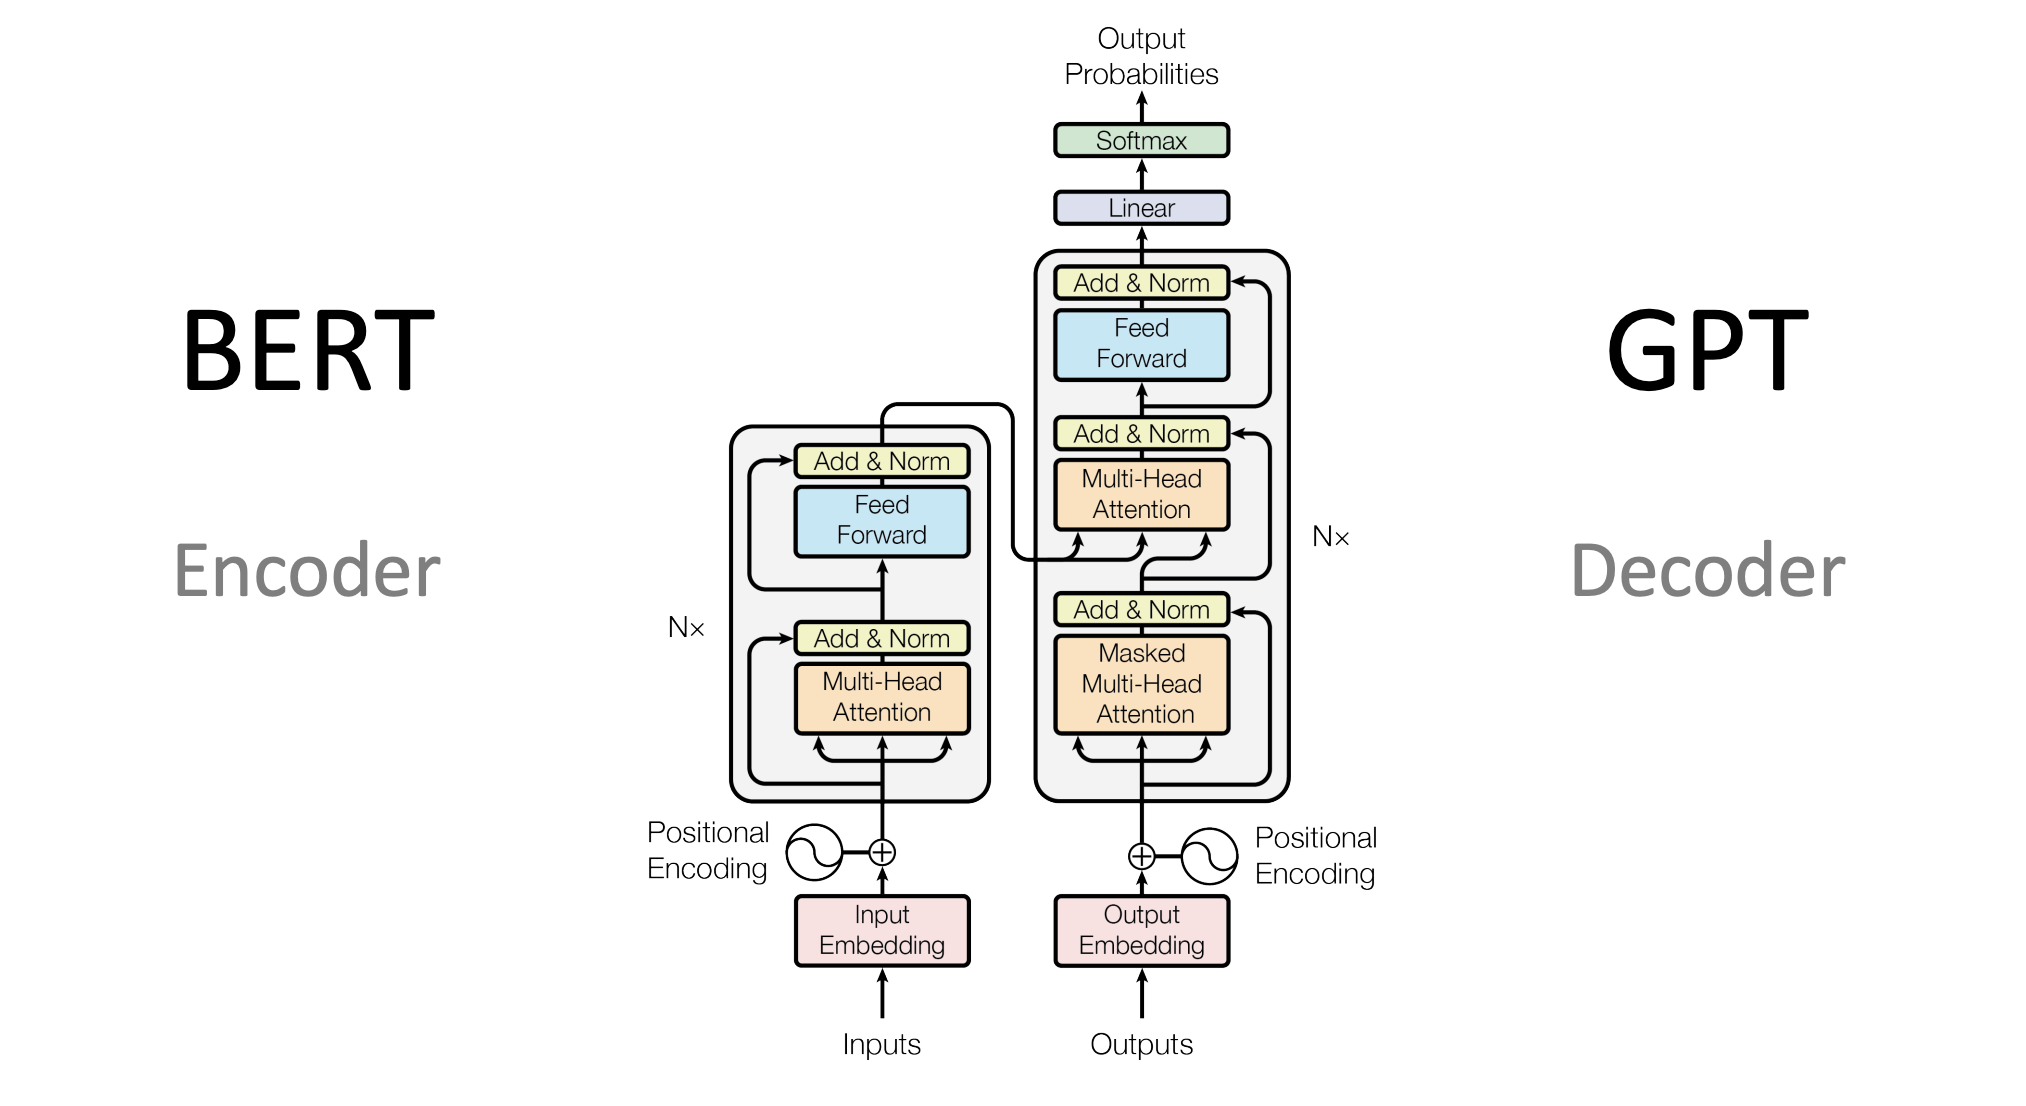All three types of embeddings—token, segment, and position—need to share a consistent output size, typically 768 in this context. This uniform size enables their summation into a single embedded output. The "padding_idx" is set to 0, ensuring that the pad token remains at 0 and remains unchanged during training.

In [ ]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):
            # for each dimension of the each position
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

## **BERT Architecture**
BERT uses the encoder part of the transformer architecture so that it understands semantic and syntactic language information.

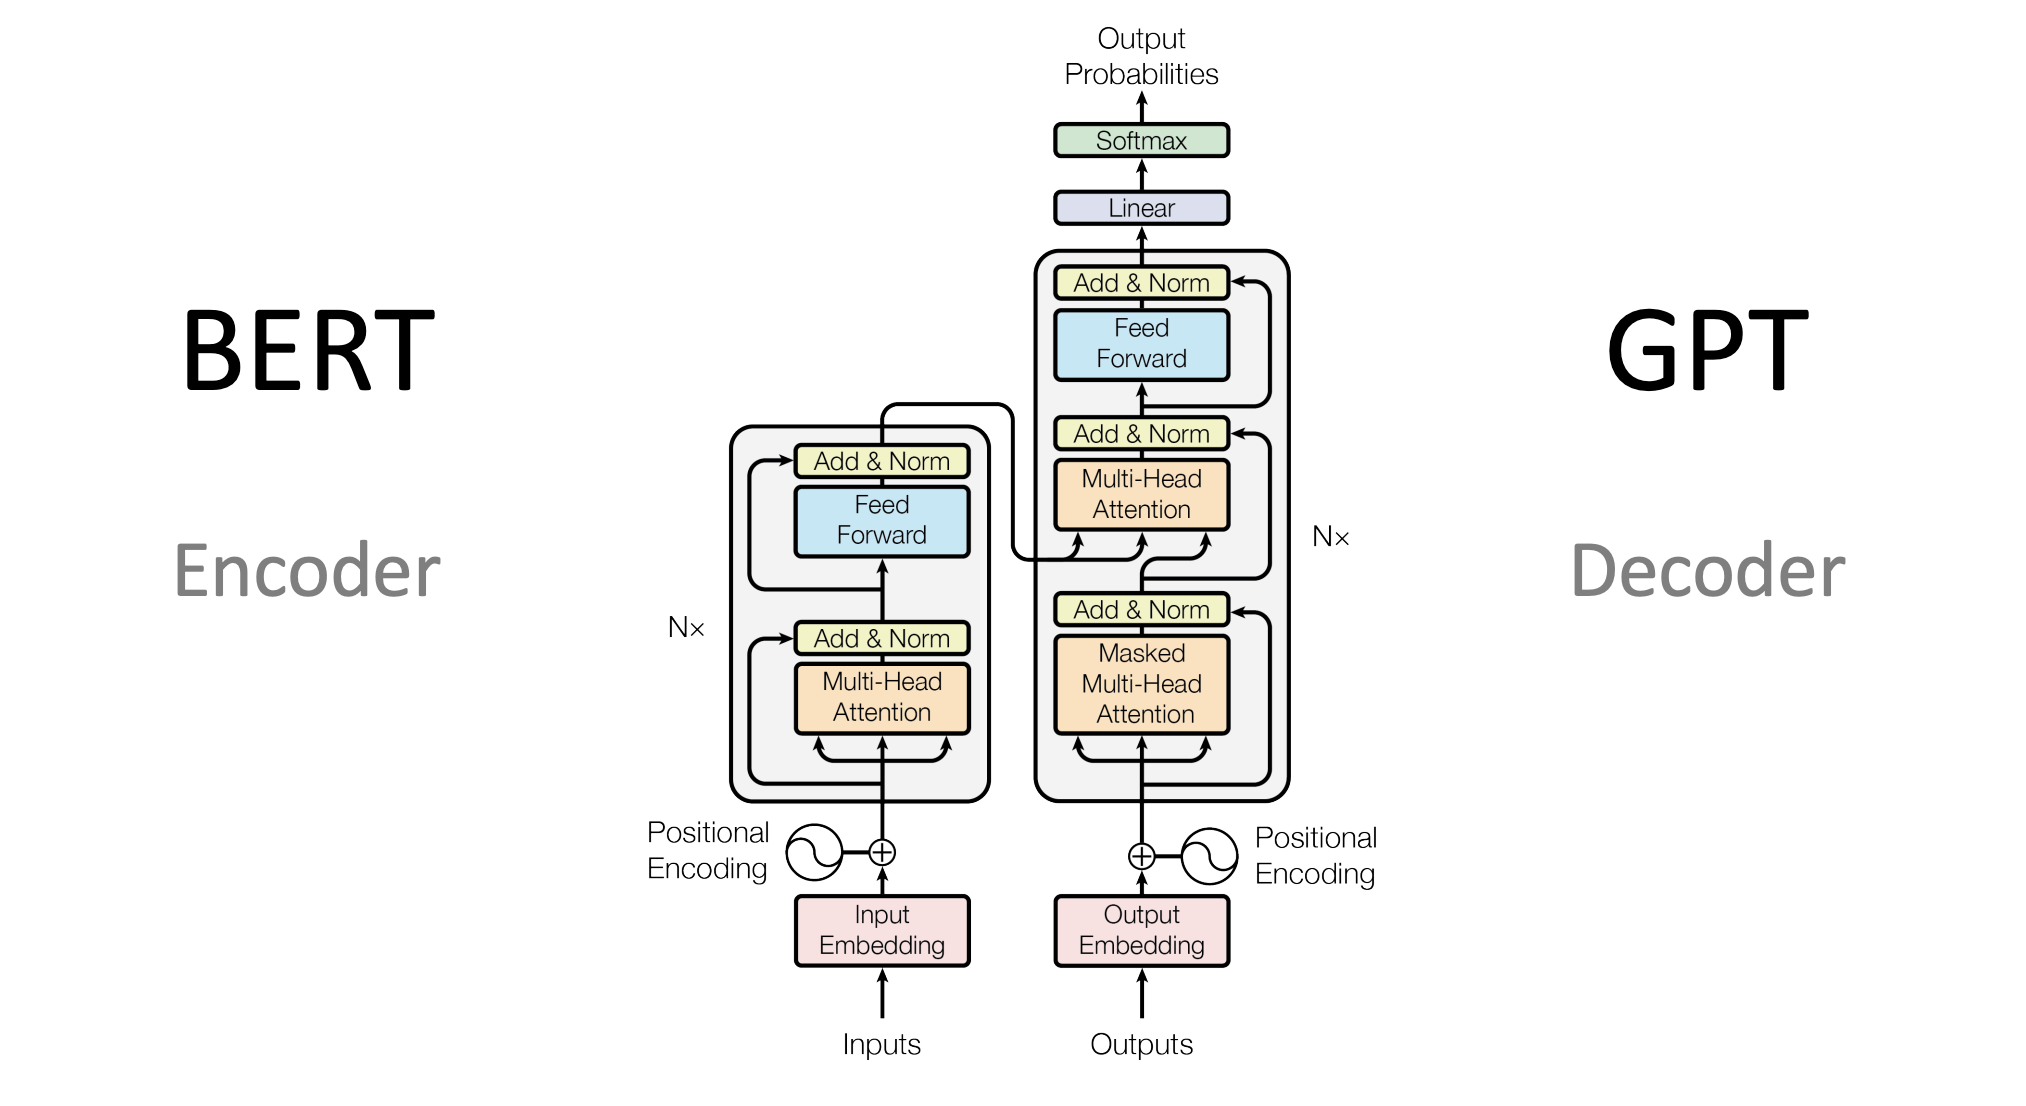
### **Multi Head Attention**
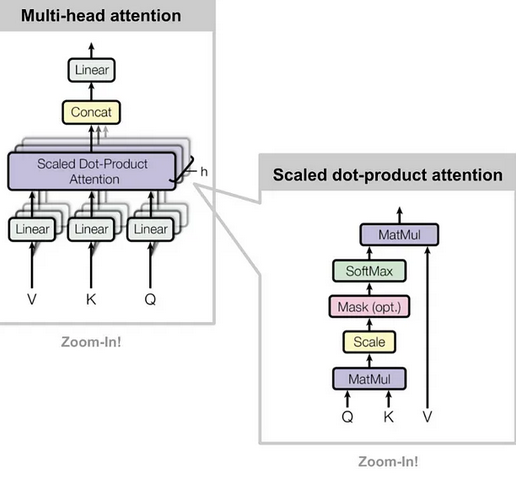

In the MultiHeadedAttention class, the purpose is to enable simultaneous attention to diverse information across different positions and representational spaces. It achieves this by splitting the hidden size (d_model=768) into heads (12). The input tensors (query, key, and value) undergo linear projection to form sets of d_k-dimensional vectors for each head.

The attention score matrix is computed according to equation.
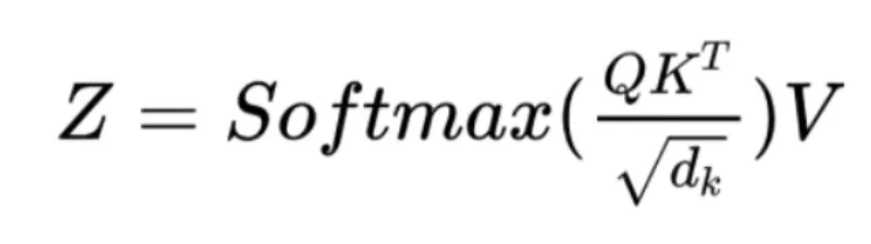




where Q, K, V are identical and linear transformation of input embeddings. The one thing that need more attention is the shape of input tensor, therefore, .permute() function is applied to amend the shape of tensor to fulfil the requirement for dot product.


The final output results from a weighted sum of value(V) tensors, where weights are determined by the softmax of the scaled dot-product between query and key vectors.

The EncoderLayer class comprises two sublayers:

    *  MultiHeadedAttention: Handles multi-headed self-attention for computing attention weights within the input sequence.
    *  FeedForward: Employs a feedforward network with one hidden layer, applying a non-linear activation function (GELU) to produce a d_model-dimensional output.

Both sublayers feature a residual connection followed by layer normalization (LayerNorm(x + Sublayer(x))). Residual connections mitigate the vanishing gradient problem in deep networks.











In [ ]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads=12,
        feed_forward_hidden=768 * 4,
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## **Final BERT Model**
Next, we will integrate the encoder layer with the attention mechanism into the final construction of BERT. Here
1. The BERT class initializes the input sequence's embedding layer and multiple layers of EncoderLayer blocks. Its forward method incorporates attention masking for padded tokens, embeds the input sequence, and passes it through the encoder blocks to generate the output.

2. The NextSentencePrediction class is a binary classification model using the BERT output to predict whether the input contains consecutive sentences. Its forward method employs linear transformation and log softmax to predict probabilities for the two classes.

3. The MaskedLanguageModel class is a multi-class classification model using the BERT output to predict original tokens for masked input. Its forward method applies linear transformation and log softmax to predict probabilities for each token in the vocabulary.

4. The BERTLM class combines BERT, NextSentencePrediction, and MaskedLanguageModel to form a comprehensive BERT language model.

In [ ]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

## Optimizer
The original BERT model was trained using Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1810.04805).
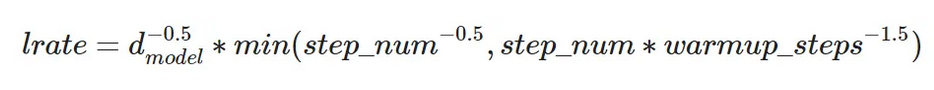


In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## **Trainer**
The BERTTrainer class encompasses the train() and test() methods, both invoking the iteration() method to iterate through the provided dataloader (train or test) for a designated epoch. Within the iteration() method, the model's loss and accuracy on the given data are computed, and parameters are updated through backpropagation and optimization. The training progress is logged with a progress bar, and at the end of each epoch, the average loss and accuracy are printed. This facilitates a test run for the BERT model on processed data with a low number of epochs.

In [ ]:
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )

## Training(test run for 20 epochs)

In [ ]:
'''test run'''

train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 20

for epoch in range(epochs):
  bert_trainer.train(epoch)

Total Parameters: 46699434


EP_train:0:   0%|| 1/6926 [00:10<19:51:32, 10.32s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 10.958110809326172, 'avg_acc': 53.125, 'loss': 10.958110809326172}


EP_train:0:   0%|| 11/6926 [01:31<14:29:25,  7.54s/it]

{'epoch': 0, 'iter': 10, 'avg_loss': 10.951775550842285, 'avg_acc': 50.28409090909091, 'loss': 10.913164138793945}


EP_train:0:   0%|| 21/6926 [02:47<13:53:12,  7.24s/it]

{'epoch': 0, 'iter': 20, 'avg_loss': 10.897532372247605, 'avg_acc': 50.74404761904761, 'loss': 10.772961616516113}


EP_train:0:   0%|| 31/6926 [03:57<13:19:39,  6.96s/it]

{'epoch': 0, 'iter': 30, 'avg_loss': 10.828654566118795, 'avg_acc': 49.193548387096776, 'loss': 10.657803535461426}


EP_train:0:   1%|| 41/6926 [05:08<13:46:41,  7.20s/it]

{'epoch': 0, 'iter': 40, 'avg_loss': 10.747354600487686, 'avg_acc': 50.07621951219512, 'loss': 10.427046775817871}


EP_train:0:   1%|| 51/6926 [06:18<13:21:08,  6.99s/it]

{'epoch': 0, 'iter': 50, 'avg_loss': 10.669415118647557, 'avg_acc': 50.79656862745098, 'loss': 10.306869506835938}


EP_train:0:   1%|| 61/6926 [07:34<16:16:06,  8.53s/it]

{'epoch': 0, 'iter': 60, 'avg_loss': 10.587412333879314, 'avg_acc': 51.17827868852459, 'loss': 10.106545448303223}


EP_train:0:   1%|| 71/6926 [08:55<14:23:31,  7.56s/it]

{'epoch': 0, 'iter': 70, 'avg_loss': 10.517913764631244, 'avg_acc': 51.1443661971831, 'loss': 10.046990394592285}


EP_train:0:   1%|| 81/6926 [10:08<13:52:45,  7.30s/it]

{'epoch': 0, 'iter': 80, 'avg_loss': 10.457466431605964, 'avg_acc': 51.11882716049383, 'loss': 9.933958053588867}


EP_train:0:   1%|| 91/6926 [11:22<14:48:09,  7.80s/it]

{'epoch': 0, 'iter': 90, 'avg_loss': 10.398768362108168, 'avg_acc': 50.755494505494504, 'loss': 9.777241706848145}


EP_train:0:   1%|| 101/6926 [12:34<13:45:31,  7.26s/it]

{'epoch': 0, 'iter': 100, 'avg_loss': 10.340587361024157, 'avg_acc': 50.21658415841584, 'loss': 9.676578521728516}


EP_train:0:   2%|| 111/6926 [13:45<13:29:35,  7.13s/it]

{'epoch': 0, 'iter': 110, 'avg_loss': 10.283435177158665, 'avg_acc': 50.112612612612615, 'loss': 9.605106353759766}


EP_train:0:   2%|| 121/6926 [14:56<13:09:50,  6.96s/it]

{'epoch': 0, 'iter': 120, 'avg_loss': 10.226039941645851, 'avg_acc': 49.89669421487603, 'loss': 9.642315864562988}


EP_train:0:   2%|| 131/6926 [16:09<13:36:07,  7.21s/it]

{'epoch': 0, 'iter': 130, 'avg_loss': 10.16996835752298, 'avg_acc': 49.97614503816794, 'loss': 9.409470558166504}


EP_train:0:   2%|| 141/6926 [17:21<13:12:28,  7.01s/it]

{'epoch': 0, 'iter': 140, 'avg_loss': 10.108867949627815, 'avg_acc': 50.22163120567376, 'loss': 9.182167053222656}


EP_train:0:   2%|| 151/6926 [18:33<13:29:22,  7.17s/it]

{'epoch': 0, 'iter': 150, 'avg_loss': 10.048878808684696, 'avg_acc': 49.937913907284766, 'loss': 8.898884773254395}


EP_train:0:   2%|| 161/6926 [19:44<13:13:57,  7.04s/it]

{'epoch': 0, 'iter': 160, 'avg_loss': 9.982916067846073, 'avg_acc': 50.019409937888206, 'loss': 9.03624153137207}


EP_train:0:   2%|| 171/6926 [20:54<13:04:07,  6.96s/it]

{'epoch': 0, 'iter': 170, 'avg_loss': 9.912635914763513, 'avg_acc': 50.07309941520468, 'loss': 8.391061782836914}


EP_train:0:   3%|| 181/6926 [22:05<13:11:17,  7.04s/it]

{'epoch': 0, 'iter': 180, 'avg_loss': 9.846907130921085, 'avg_acc': 49.706491712707184, 'loss': 8.503145217895508}


EP_train:0:   3%|| 191/6926 [23:13<12:37:24,  6.75s/it]

{'epoch': 0, 'iter': 190, 'avg_loss': 9.780436126349484, 'avg_acc': 49.75458115183246, 'loss': 8.610864639282227}


EP_train:0:   3%|| 201/6926 [24:22<12:48:07,  6.85s/it]

{'epoch': 0, 'iter': 200, 'avg_loss': 9.719949418632545, 'avg_acc': 49.75124378109453, 'loss': 8.4287748336792}


EP_train:0:   3%|| 211/6926 [25:31<12:41:31,  6.80s/it]

{'epoch': 0, 'iter': 210, 'avg_loss': 9.65851213355765, 'avg_acc': 49.83708530805687, 'loss': 8.554012298583984}


EP_train:0:   3%|| 221/6926 [26:38<12:31:43,  6.73s/it]

{'epoch': 0, 'iter': 220, 'avg_loss': 9.591130355904005, 'avg_acc': 49.73133484162896, 'loss': 8.15536880493164}


EP_train:0:   3%|| 231/6926 [27:48<12:41:27,  6.82s/it]

{'epoch': 0, 'iter': 230, 'avg_loss': 9.535020545447544, 'avg_acc': 49.756493506493506, 'loss': 8.359468460083008}


EP_train:0:   3%|| 241/6926 [28:56<12:39:35,  6.82s/it]

{'epoch': 0, 'iter': 240, 'avg_loss': 9.472424835584965, 'avg_acc': 49.83143153526971, 'loss': 7.894764423370361}


EP_train:0:   4%|| 251/6926 [30:05<13:10:35,  7.11s/it]

{'epoch': 0, 'iter': 250, 'avg_loss': 9.411859804890545, 'avg_acc': 49.85059760956175, 'loss': 8.109294891357422}


EP_train:0:   4%|| 261/6926 [31:13<12:29:55,  6.75s/it]

{'epoch': 0, 'iter': 260, 'avg_loss': 9.354955258497332, 'avg_acc': 49.820402298850574, 'loss': 7.956428527832031}


EP_train:0:   4%|| 271/6926 [32:22<12:45:53,  6.91s/it]

{'epoch': 0, 'iter': 270, 'avg_loss': 9.303287539534903, 'avg_acc': 49.91928044280443, 'loss': 8.030780792236328}


EP_train:0:   4%|| 281/6926 [33:32<13:03:51,  7.08s/it]

{'epoch': 0, 'iter': 280, 'avg_loss': 9.25231780870105, 'avg_acc': 49.87766903914591, 'loss': 7.92077112197876}


EP_train:0:   4%|| 291/6926 [34:41<12:49:13,  6.96s/it]

{'epoch': 0, 'iter': 290, 'avg_loss': 9.197796659371287, 'avg_acc': 49.69931271477663, 'loss': 7.411643028259277}


EP_train:0:   4%|| 301/6926 [35:51<12:39:29,  6.88s/it]

{'epoch': 0, 'iter': 300, 'avg_loss': 9.147789765037967, 'avg_acc': 49.667774086378735, 'loss': 7.41175651550293}


EP_train:0:   4%|| 311/6926 [37:00<12:34:10,  6.84s/it]

{'epoch': 0, 'iter': 310, 'avg_loss': 9.102897575047239, 'avg_acc': 49.59807073954984, 'loss': 7.594865798950195}


EP_train:0:   5%|| 321/6926 [38:08<12:43:30,  6.94s/it]

{'epoch': 0, 'iter': 320, 'avg_loss': 9.056701031800742, 'avg_acc': 49.484034267912776, 'loss': 7.541324138641357}


EP_train:0:   5%|| 331/6926 [39:16<12:30:21,  6.83s/it]

{'epoch': 0, 'iter': 330, 'avg_loss': 9.006890386252966, 'avg_acc': 49.51850453172205, 'loss': 7.170445919036865}


EP_train:0:   5%|| 341/6926 [40:24<12:31:29,  6.85s/it]

{'epoch': 0, 'iter': 340, 'avg_loss': 8.961561981883566, 'avg_acc': 49.660923753665685, 'loss': 7.288496017456055}


EP_train:0:   5%|| 351/6926 [41:33<12:41:52,  6.95s/it]

{'epoch': 0, 'iter': 350, 'avg_loss': 8.921389147766636, 'avg_acc': 49.75961538461539, 'loss': 7.416752815246582}


EP_train:0:   5%|| 361/6926 [42:42<12:28:09,  6.84s/it]

{'epoch': 0, 'iter': 360, 'avg_loss': 8.879627473466615, 'avg_acc': 49.74030470914128, 'loss': 7.454338550567627}


EP_train:0:   5%|| 371/6926 [43:51<12:26:03,  6.83s/it]

{'epoch': 0, 'iter': 370, 'avg_loss': 8.838404762134397, 'avg_acc': 49.865229110512125, 'loss': 7.4586687088012695}


EP_train:0:   6%|| 381/6926 [44:59<12:26:17,  6.84s/it]

{'epoch': 0, 'iter': 380, 'avg_loss': 8.796620823266938, 'avg_acc': 49.770341207349084, 'loss': 7.59025764465332}


EP_train:0:   6%|| 391/6926 [46:08<12:32:28,  6.91s/it]

{'epoch': 0, 'iter': 390, 'avg_loss': 8.756762132620263, 'avg_acc': 49.74424552429667, 'loss': 7.333840847015381}


EP_train:0:   6%|| 401/6926 [47:16<12:21:40,  6.82s/it]

{'epoch': 0, 'iter': 400, 'avg_loss': 8.718304348705415, 'avg_acc': 49.71165835411471, 'loss': 7.474299430847168}


EP_train:0:   6%|| 411/6926 [48:25<12:34:30,  6.95s/it]

{'epoch': 0, 'iter': 410, 'avg_loss': 8.682815066799341, 'avg_acc': 49.650243309002434, 'loss': 6.849303245544434}


EP_train:0:   6%|| 421/6926 [49:36<12:48:38,  7.09s/it]

{'epoch': 0, 'iter': 420, 'avg_loss': 8.645294649300835, 'avg_acc': 49.51009501187649, 'loss': 7.051878452301025}


EP_train:0:   6%|| 431/6926 [50:45<12:33:02,  6.96s/it]

{'epoch': 0, 'iter': 430, 'avg_loss': 8.611422482333438, 'avg_acc': 49.56496519721578, 'loss': 7.620230197906494}


EP_train:0:   6%|| 441/6926 [51:54<12:27:20,  6.91s/it]

{'epoch': 0, 'iter': 440, 'avg_loss': 8.577742454416358, 'avg_acc': 49.57482993197279, 'loss': 7.401723861694336}


EP_train:0:   7%|| 451/6926 [53:05<12:31:12,  6.96s/it]

{'epoch': 0, 'iter': 450, 'avg_loss': 8.542566944384522, 'avg_acc': 49.605044345898, 'loss': 7.659453868865967}


EP_train:0:   7%|| 461/6926 [54:15<12:37:54,  7.03s/it]

{'epoch': 0, 'iter': 460, 'avg_loss': 8.51275490266382, 'avg_acc': 49.69495661605206, 'loss': 7.293619632720947}


EP_train:0:   7%|| 471/6926 [55:25<12:43:36,  7.10s/it]

{'epoch': 0, 'iter': 470, 'avg_loss': 8.48324365575349, 'avg_acc': 49.761146496815286, 'loss': 7.224963188171387}


EP_train:0:   7%|| 481/6926 [56:37<13:12:17,  7.38s/it]

{'epoch': 0, 'iter': 480, 'avg_loss': 8.448585077035947, 'avg_acc': 49.71413721413722, 'loss': 7.156365871429443}


EP_train:0:   7%|| 491/6926 [57:48<12:38:05,  7.07s/it]

{'epoch': 0, 'iter': 490, 'avg_loss': 8.418031791562704, 'avg_acc': 49.80269857433808, 'loss': 6.835874557495117}


EP_train:0:   7%|| 501/6926 [58:58<12:30:07,  7.01s/it]

{'epoch': 0, 'iter': 500, 'avg_loss': 8.386933814027827, 'avg_acc': 49.86901197604791, 'loss': 6.803328037261963}


EP_train:0:   7%|| 511/6926 [1:00:10<12:41:40,  7.12s/it]

{'epoch': 0, 'iter': 510, 'avg_loss': 8.355855980964556, 'avg_acc': 49.896037181996086, 'loss': 7.047236442565918}


EP_train:0:   8%|| 521/6926 [1:01:21<12:27:44,  7.00s/it]

{'epoch': 0, 'iter': 520, 'avg_loss': 8.32762297192828, 'avg_acc': 49.96401151631478, 'loss': 7.204107284545898}


EP_train:0:   8%|| 531/6926 [1:02:31<12:31:01,  7.05s/it]

{'epoch': 0, 'iter': 530, 'avg_loss': 8.297926939588931, 'avg_acc': 49.929378531073446, 'loss': 6.769248008728027}


EP_train:0:   8%|| 541/6926 [1:03:41<12:23:49,  6.99s/it]

{'epoch': 0, 'iter': 540, 'avg_loss': 8.27004507068345, 'avg_acc': 49.90757855822551, 'loss': 6.571481227874756}


EP_train:0:   8%|| 551/6926 [1:04:54<12:51:48,  7.26s/it]

{'epoch': 0, 'iter': 550, 'avg_loss': 8.240459424830608, 'avg_acc': 49.90358439201452, 'loss': 6.877628326416016}


EP_train:0:   8%|| 561/6926 [1:06:05<12:41:56,  7.18s/it]

{'epoch': 0, 'iter': 560, 'avg_loss': 8.210203486117875, 'avg_acc': 49.98328877005348, 'loss': 6.729907512664795}


EP_train:0:   8%|| 571/6926 [1:07:14<12:03:15,  6.83s/it]

{'epoch': 0, 'iter': 570, 'avg_loss': 8.181549347845769, 'avg_acc': 50.00547285464098, 'loss': 6.443082332611084}


EP_train:0:   8%|| 581/6926 [1:08:23<11:56:39,  6.78s/it]

{'epoch': 0, 'iter': 580, 'avg_loss': 8.153814743389976, 'avg_acc': 49.96234939759036, 'loss': 6.478708267211914}


EP_train:0:   9%|| 591/6926 [1:09:32<12:06:20,  6.88s/it]

{'epoch': 0, 'iter': 590, 'avg_loss': 8.127062453836354, 'avg_acc': 49.94712351945855, 'loss': 6.133641719818115}


EP_train:0:   9%|| 601/6926 [1:10:41<12:09:34,  6.92s/it]

{'epoch': 0, 'iter': 600, 'avg_loss': 8.101444115852953, 'avg_acc': 50.0, 'loss': 6.575555801391602}


EP_train:0:   9%|| 611/6926 [1:11:49<11:54:55,  6.79s/it]

{'epoch': 0, 'iter': 610, 'avg_loss': 8.076502138190886, 'avg_acc': 49.95396890343699, 'loss': 6.418780326843262}


EP_train:0:   9%|| 621/6926 [1:12:59<12:24:59,  7.09s/it]

{'epoch': 0, 'iter': 620, 'avg_loss': 8.050827565400496, 'avg_acc': 49.94967793880837, 'loss': 6.843389511108398}


EP_train:0:   9%|| 628/6926 [1:13:47<12:03:34,  6.89s/it]

## Conclusion
Training the extensive BERT model from scratch is impractical without significant resources and compute power. A more feasible approach involves downloading a pre-trained model and fine-tuning it for a specific downstream task, providing a more reproducible and resource-efficient solution.